### 图像轮廓

In [1]:
import cv2
def cv_show(name,img):
    cv2.imshow(name,img)
    while cv2.waitKey(100) != 27:# loop if not get ESC
        if cv2.getWindowProperty(name,cv2.WND_PROP_VISIBLE) <= 0:
            break
    cv2.destroyWindow(name)

#### cv2.findContours(img,mode,method)
mode:轮廓检索模式
- RETR_EXTERNAL ：只检索最外面的轮廓；
- RETR_LIST：检索所有的轮廓，并将其保存到一条链表当中；
- RETR_CCOMP：检索所有的轮廓，并将他们组织为两层：顶层是各部分的外部边界，第二层是空洞的边界;
- RETR_TREE：检索所有的轮廓，并重构嵌套轮廓的整个层次;

method:轮廓逼近方法
- CHAIN_APPROX_NONE：以Freeman链码的方式输出轮廓，所有其他方法输出多边形（顶点的序列）。
- CHAIN_APPROX_SIMPLE:压缩水平的、垂直的和斜的部分，也就是，函数只保留他们的终点部分。

什么是轮廓？轮廓是一系列相连的点组成的曲线，代表了物体的基本外形，相对于边缘，轮廓是连续的，边缘并不全部连续。

如何寻找轮廓？寻找轮廓的操作一般用于二值化图，所以通常会使用阈值分割或Canny边缘检测先得到二值图  

PS：寻找轮廓是针对白色物体的，一定要保证物体是白色，而背景是黑色，不然很多人在寻找轮廓时会找到图片最外面的一个框

In [26]:
img = cv2.imread('map.jpeg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)#大于127取255，小于取0
cv_show('thresh',thresh)

参数1：二值化原图  
参数2：轮廓的查找方式，一般使用cv2.RETR_TREE，表示提取所有的轮廓并建立轮廓间的层级。  
参数3：轮廓的近似方法。比如对于一条直线，我们可以存储该直线的所有像素点（cv2.CHAIN_APPOX_NONE），也可以只存储起点和终点。使用 cv2.CHAIN_APPROX_SIMPLE 就表示用尽可能少的像素点表示轮廓.

In [27]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) #新版的opencv调用只返回两个参数,此时本人用的版本是4.1.2

contours即为轮廓的像素集合（可能有多个轮廓，需要找到自己要提取的轮廓）

绘制轮廓

In [47]:
#传入绘制图像，轮廓，轮廓索引，颜色模式，线条厚度
# 注意需要copy,要不原图会变。。。
draw_img = img.copy()
#cv2.drawContours参数：图片，轮廓集合，第几个轮廓(-1表示绘制所有轮廓) ，画笔颜色((0,0,255)表示红色)，画笔宽度,
res = cv2.drawContours(draw_img,contours,110,(0,0,255),2)     
cv_show('res',res)

In [32]:
print(len(contours))

610


### 轮廓特征  
计算物体的周长、面积、质心、最小外接矩形等   
OpenCV函数：cv2.contourArea(), cv2.arcLength(), cv2.approxPolyDP()等 

In [36]:
#面积
cv2.contourArea(cont)

365715.0

In [46]:
#查看每个较大点的轮廓
for index,area in enumerate(contours,0) :
    if cv2.contourArea(area)>100:
        print(cv2.contourArea(area),index)

365715.0 0
530.0 61
200.0 64
139.5 88
627.0 110
161.0 119
102.0 124
109.0 136
695.0 164
110.5 205
524.5 224
380.5 242
316.5 243
227.0 253
106.5 273
108.0 286
106.0 315
5552.0 333
1726.5 339
122.0 344
129.5 348
135.0 370
155.0 377
101.0 384
302.5 395
163.0 398
359.0 407
113.0 412
100.5 420
123.5 423
261.5 431
520.5 441
100.5 442
297.0 446
119.0 457
216.0 470
268.0 484
116.0 490
106.5 510
637.5 519
113.5 557
100.5 560
155.5 579
285.0 585
144.0 586
2087.0 595
314.0 597
114.5 599
113.0 608


In [48]:
cont = contours[0]

In [37]:
#周长
cv2.arcLength(cont,True)    #True表示闭合

2424.0

当轮廓有毛刺的时候，我们希望能够做轮廓近似，将毛刺去掉，大体思想是将曲线用直线代替，但是有个长度的阈值需要自己设定。

### 轮廓近似  
将轮廓形状近似到另外一种由更少点组成的轮廓形状，新轮廓的点的数目由我们设定的准确度来决定，用的Douglas-Peucker算法。

In [50]:
#先找到轮廓
img_contours = cv2.imread('contours2.png')
gray = cv2.cvtColor(img_contours,cv2.COLOR_BGR2GRAY)    #灰度处理
ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY) #二值化
#找轮廓
contours2, hierarchy2 = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
#第一个轮廓
cnt = contours2[0]

draw_img = img_contours.copy()
res = cv2.drawContours(draw_img,[cnt],-1,(0,0,255),2)
cv_show('res',res)

In [55]:
#行多边形逼近，得到多边形的角点
epsilon = 0.15 * cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)

draw_img = img_contours.copy()
res = cv2.drawContours(draw_img,[approx],-1,(0,0,255),2)
cv_show('res',res)

其中cv2.approxPolyDP() 的参数2($epsilon$)是一个距离值，表示多边形的轮廓接近实际轮廓的程度，值越小，越精确；参数3表示是否闭合。

对于轮廓我们还可以做一些额外的操作，比如外接矩形，外接圆，外界椭圆等等。
### 边界矩形


In [68]:
img_contours = cv2.imread('contours2.png')
gray = cv2.cvtColor(img_contours,cv2.COLOR_BGR2GRAY)    #灰度处理
ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY) #二值化
#找轮廓
contours2, hierarchy2 = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
#第一个轮廓
cnt = contours2[0]

img = img_contours.copy()
x,y,w,h = cv2.boundingRect(cnt)
img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
cv_show('img',img)

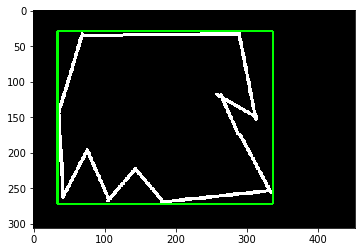

In [69]:
plt.imshow(img)

In [70]:
area = cv2.contourArea(cnt)
x, y, w, h = cv2.boundingRect(cnt)
rect_area = w * h
extent = float(area) / rect_area
print ('轮廓面积与边界矩形比',extent)

轮廓面积与边界矩形比 0.7800798598378357


### 外接圆

In [71]:
(x,y),radius = cv2.minEnclosingCircle(cnt)
center = (int(x), int(y))
radius = int(radius)
img = img_contours.copy()
img = cv2.circle(img,center,radius,(0,255,0),2)
cv_show('img',img)


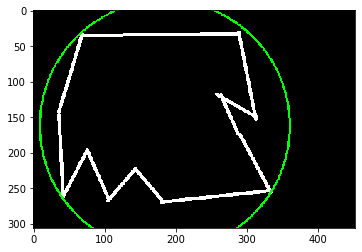

In [72]:
plt.imshow(img)